In [1]:
"""
This script provides functions to read in and analyse spectra detected with the MISS-1 continuum detection script.
Noise in detected spectra is reduced by averaging and also reference spectra are determined.

Several filtering methods are used. Most effective is an additional detection of the red auroral emission line to remove events in cloudy conditions.
Events are seperated in different populations based on relative enhancement between detected and reference spectra.
Events are matched with Sony camera images for further filtering.

The output of this script is pdf files that include filtered events with the respective spectral image, detected and reference spectra and Sony image.

The first two defined functions are again from the KHO-MISS/SpectralCalibration/miss_read_spectral.py script.

Created on May 9 2025

@author: Tim Hulsen
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, medfilt2d
import warnings
import re
import datetime
import shutil
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

In [2]:
# A user called Felix wrote a nice short reading routine for ASCII PGM-files
# https://stackoverflow.com/questions/46944048/how-to-read-pgm-p2-image-in-python
#
# The commonly used PIL for image reading in python seems to have trouble
# handling the comments in PGM-files, even though the comments are part
# of the "standard" for PNM-format.

def readpgm(name):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2', 'File not an ASCII PGM-file'

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    data=(np.array(data[3:]),(data[1],data[0]),data[2])
    return np.reshape(data[0],data[1])

In [3]:
def read_miss_spectral(filename):
    im=readpgm(filename)


    # Estimate the background level from an image corner and
    # remove the pixel offset
    bg_estimate=np.mean(im[0:29,0:29])
    im=np.maximum(im-bg_estimate,0).transpose()


    # From quick calibration using auroral emission lines,
    # see plot_misspeaks.m in the Matlab source code

    bluepoly=np.poly1d([-0.000401186790506, 0.118021155830754,
                        86.670020639834831]);
    redpoly=np.poly1d([-0.0003147574819, 0.1045665634675,
                            656.6050051599582]);
    greenpoly=np.poly1d([-0.0003805469556, 0.1139447884417,
                         462.5405056759545]);

    # Create a spectral image
    # - use data between rows 70 and 270 (needs scan angle calibration!)
    # - interpolate data from 400..700nm

    scanangle=np.arange(0,200)
    wavelengths=np.arange(400,701)
    spectralimage=np.zeros([len(scanangle),len(wavelengths)])
    colIndex=np.arange(0,im.shape[1])

    for alpha in scanangle:
        row=70+alpha
        blueline=bluepoly(row)      # Locations of the auroral emission lines
        redline=redpoly(row)        # at this scan angle, or image row in raw
        greenline=greenpoly(row)    # image data
        lambdas=np.polynomial.Polynomial.fit([427.8, 557.7, 630.0],
                                             [blueline, greenline, redline],2)
        cols=lambdas(wavelengths)
        thisrowvalues=im[row,:]
        spectralvalues=np.interp(cols,colIndex,thisrowvalues)
        spectralimage[alpha,:]=spectralvalues

    return spectralimage

In [4]:
def mean_spectrum_analysis_rol_avg(spectralimage, peak_index):   

    """
    Based on the output from the MISS-1 continuum detection script.
    Input a spectral image as read from the filenames stored in the text files with corresponding detected row indeces.

    Find the detected peak in the row-wise mean and compute the full-width-half-maximum.
    The FWHM is used as a range over which the spectrum is averaged to reduce noise.

    Next, the background or reference spectrum is determined, which is defined as the spectrum with minimum mean emission.
    A simple rolling average of the row-wise mean is computed with a window size equal to the FWHM of the detected peak. The row with the minimum value 
    is chosen as the reference spectrum and averaged over the same range of rows to ensure similar noise suppression.

    Output the averaged detected spectrum, the averaged reference spectrum, detected row index and the row index of the reference spectrum.
    """
    
    data = np.sqrt(spectralimage)
    
    # Calculate the row-wise mean
    row_means = np.mean(data, axis=1)
    
    # Determines FWHM of peak identified as possible continuum
    # We use index 0 as a proxy because the peak_widths function only accepts 1D arrays
    width = peak_widths(row_means, np.array((peak_index,0)), rel_height=0.5)
    
    # Determine and extract range of rows around identified peak
    index_deviation = round(width[0][0]/2)
    row_range_data = data[peak_index-index_deviation:peak_index+index_deviation,:]
    
    # Compute the average signal within the range of rows to reduce noise
    mean_spectrum = np.mean(row_range_data, axis=0)
    
    # Calculate the row-wise mean minimum intensity using a simple moving average
    # This will be the 'clear sky' reference, use same range of rows for equal noise suppression

    # Use same width as average around row of identified peak
    window_size = round(width[0][0])
    # Simple averaging, not weighted
    weights = np.ones(window_size) / window_size

    # Valid mode to remove boundary effects
    sma = np.convolve(row_means, weights, mode='valid')

    # Find row index with minimum average spectrum intensity and compensate for finite window size
    # Do not include boundaries since here the spectrum has a lower intensity in general
    row_mean_min = np.argmin(sma[10:-10]) + 10 + index_deviation

    # Compute minimum 'clear-sky' spectrum
    mean_clear_spectrum = np.mean(data[row_mean_min-index_deviation:row_mean_min+index_deviation,:], axis=0)
    
    return mean_spectrum, mean_clear_spectrum, peak_index, row_mean_min

In [5]:
# Ignore warnings caused by the peak_widths function working on the proxy index
warnings.filterwarnings("ignore", message="some peaks have a prominence of 0")
warnings.filterwarnings("ignore", message="some peaks have a width of 0")

### Example of defined function

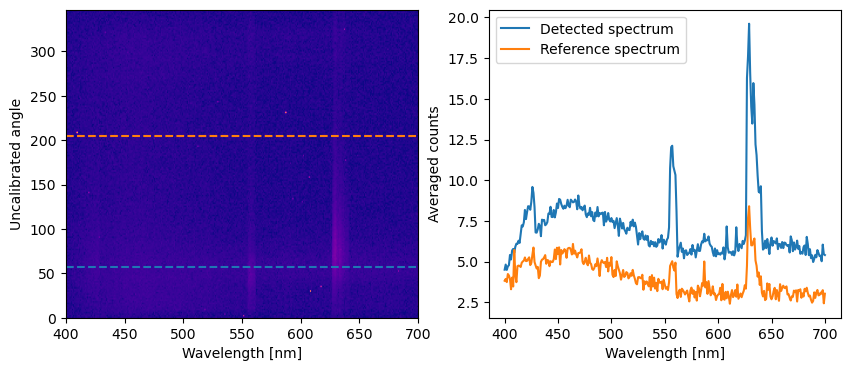

In [10]:
# We use the same example as in the MISS-1 continuum detection script
# There we detected a peak at row index 167
filename = os.path.join('Example files','MISS-20240211-055000.pgm')
spectralimage = read_miss_spectral(filename)

mean_spectrum, mean_clear_spectrum, peak_index, row_mean_min = mean_spectrum_analysis_rol_avg(spectralimage, 167)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',
          extent=[400,700, 0, 347])
# Highlight the peak detected at index 167 with a blue dashed line
ax1.axhline(y=347-(347/200)*peak_index, color='C0', linestyle='dashed')
# Highlight the row of the reference spectrum with an orange dashed line
ax1.axhline(y=347-(347/200)*row_mean_min, color='C1', linestyle='dashed')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Uncalibrated angle')

ax2.plot(np.linspace(400,700,301), mean_spectrum)
ax2.plot(np.linspace(400,700,301), mean_clear_spectrum)
ax2.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("Averaged counts")
ax2.legend(("Detected spectrum", "Reference spectrum"));

### Reading detection output

In [ ]:
"""
So... this is where the fun begins.

This piece of code loops over all text files containing the output of the MISS-1 continuum detection script. Empty text files are skipped.
The .pgm filenames and detected row indeces are used in the mean spectrum analysis function to compute the averaged detected spectrumm, reference
spectrum and corresponding row indeces.

This information is stored in the list "result" where each entry corresponds to a unique event.
Corresponding .pgm filenames are stored in the list "filename_save". 
From these two lists further analysis is conducted.
"""

# Initialize lists
result = []
filename_save = []

# Used to access output from the MISS-1 continuum detection script
# Loop over all years of available data
years = ['list of years']
for year in years:
    for month in os.listdir(os.path.join(your_output_directory,year)):
        missFiles = []
        peak_indeces = []
        for filename in os.listdir(os.path.join(your_output_directory,year,month)):

            file_path = os.path.join(your_output_directory,year,month,filename)
            # Check if file is empty
            if os.path.getsize(file_path) == 0:
                continue

            # Open text file
            with open(file_path, 'r') as file:
                # Each line has two columns
                # The first column has the .pgm filename corresponding to the event of interest
                # The second column has the row index where a peak was detected in the continuum detection script
                for line in file:
                    columns = line.split()

                    # Append .pgm filenames and corresponding row index to temporary lists
                    missFiles.append(columns[0])
                    peak_indeces.append(" ".join(columns[1:]).strip("[]"))

        for file, index in zip(missFiles, peak_indeces):

            # Use each stored .pgm file to read the spectral image
            missFile = os.path.join(your_data_directory,'MISS-1',year,month,file[11:13],file)   
            spectralimage=read_miss_spectral(missFile)

            # If multiple indeces are detected for a single MISS-1 file then only use the first one (temporary solution)
            try:
                # Compute the averaged detected spectrum and averaged reference spectrum
                # Save corresponding row indeces and .pgm filename
                result.append(mean_spectrum_analysis_rol_avg(spectralimage, int(index.split()[0])))
                filename_save.append(file)
            except:
                # Rejects files that result in an error
                print(f"{filename} gives an error")
                continue

### Post-detection analysis

In this section it is elaborated how this script was originally used with the primary goal of finding new auroral continuum emission events. Filtering is performed based on specific features observed in the data to seperate detected false positives, such as sunlit clouds, from auroral events. The original way of working is not perfect and especially handling of data can possibly be improved. 

In this analysis the data is categorized in two populations. The populations are defined by the relative spectral enhancement between the detected and reference spectrum in the 480-520 nm and 650-700 nm ranges. It is expected that enhancement between 480-520 nm is observed in the presence of continuum emission as there are no auroral emission lines in this range [1]. Between 650-700 nm there is emission from the first negative group of molecular nitrogen, often observed for intense aurora. 

[1] Spanswick et al. Association of structured continuum emission with dynamic aurora. Nat Commun 15, 10802 (2024).

In [ ]:
"""
Compute the relative spectral enhancement between 480-520 and 650-700 nm.
The ratio between these relative spectral enhancements is the basis for the definition of different populations.
"""

result_500nm_range = []
result_650nm_range = []

for i in range(len(result)):
    
    # Compute the difference between the detected spectrum and reference spectrum
    # The first relative enhancement is computed in the 480 - 520 nm range
    # In this range there should be little spectral activity even for intense aurora
    difference = np.mean(result[i][0][80:120])-np.mean(result[i][1][80:120])
    
    # The second relative enhancement is computed in the 650 - 700 nm range
    # This range is enhanced in the case of both intense aurora and continuum emission (and clouds)
    difference_2 = np.mean(result[i][0][250:300])-np.mean(result[i][1][250:300])
    
    result_500nm_range.append(difference)
    result_650nm_range.append(difference_2)

# Compute the fraction between the relative enhancements
range_fraction = result_650nm_range/result_500nm_range

#### Population 1

In [ ]:
"""
Population 1 is defined by having a similar enhancement between both 480-520 and 650-700 nm.
Continuum events, clouds and regular auroral activity are expected to belong to population 1, additional filtering is required.

After visualizing the spectral enhancements a cut-off ratio < 2 was chosen for population 1.
"""

# Extract the events with a fraction valued below 2
indeces_low_fraction = np.nonzero((0 < range_fraction) & (range_fraction < 2))[0]

# Print the amount of events for reference
len(files_low_fraction)

In [ ]:
"""
Even with several thousand spectra it is very informative to simply plot the spectra in a single figure. 
In this way features that do not belong to auroral spectra can be observed and filtered out in a direct approach

'Smooth' parabola shaped spectra are (moonlit) sunlit clouds which reflect light in the entire visible spectrum. The second type has a parabola 
centered around 460 nm with possible auroral emission lines, these are spectra with dominant blue daylight emission. The third (and most interesting) 
spectra are flat with clear auroral emission lines.
"""
plt.figure(figsize=(12,8))
for index in indeces_low_fraction:
    plt.plot(result[index][0])

In [ ]:
# Extract and save spectra with low fraction value (population 1)
files_low_fraction = [filenames[i] for i in indeces_low_fraction]
results_low_fraction = [result[i][0] for i in indeces_low_fraction]
results_low_fraction_bg = [result[i][1] for i in indeces_low_fraction]

# Also save row indeces corresponding to the identified peak and background (reference) spectrum
peak_row_index_low_fraction = [result[i][2] for i in indeces_low_fraction]
bg_row_index_low_fraction = [result[i][3] for i in indeces_low_fraction]

##### Filtering on the red auroral emission line

In [ ]:
"""
The first filtering method is based on the red auroral emission line.
It is observed that the this emission line is not distinctly present in many cloudy or daylight spectra. 

NOTE
- These events could have circumvented the red auroral emission line condition in the detection script if this emission line is sufficiently present
over the column-wise mean. 
"""

red_aurora_peaks = []
red_aurora_peak_prominences = []
red_aurora_peak_widths = []
red_aurora_peak_heights = []

for spectrum in results_low_fraction:

    # If the red auroral emission line is not detected this results in an empty entry in the red_aurora_peaks list
    peaks, properties = find_peaks(
        spectrum[225:235],
        prominence=2,  # Minimum prominence of peaks
        width=2        # Minimum width of peaks
    )

    # Save prominences and widths for tuning the amount of events that are deleted 
    red_aurora_peaks.append(peaks)
    red_aurora_peak_prominences.append(properties['prominences'])
    red_aurora_peak_widths.append(properties['widths'])

In [ ]:
"""
If an entry in the red_aurora_peaks list is empty this means that the red auroral emission line is not detected for the event with the same list index.
Only plot the spectra of events where the red auroral emission line is detected and save the list index. 
Again, based on visually inspecting the spectra it can be decided to tune the promincence and width parameters.
"""
red_aurora_filtered_index = []

plt.figure(figsize=(12,8))
for index, entry in enumerate(red_aurora_peaks):
    # If the red auroral emission line is identified save the list index of the corresponding event and plot its spectrum
    if entry.size > 0:
        plt.plot(results_low_fraction[index])
        red_aurora_filtered_index.append(index)

In [ ]:
"""
In the original analysis this filtering method reduced the amount of events in population 1 from 1761 to 355!
"""

# Extract and save spectra with distinct red auroral emission line
red_aurora_filtered_files = [files_low_fraction[i] for i in red_aurora_filtered_index]
red_aurora_filtered_results = [results_low_fraction[i] for i in red_aurora_filtered_index]
red_aurora_filtered_results_bg = [results_low_fraction_bg[i] for i in red_aurora_filtered_index]

# Again also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_red_aurora_filtered = [peak_row_index_low_fraction[i] for i in red_aurora_filtered_index]
bg_row_index_red_aurora_filtered = [bg_row_index_low_fraction[i] for i in red_aurora_filtered_index]

# Print the amount of events for reference
len(red_aurora_filtered_files)

##### Filtering on a finite relative enhancement

In [ ]:
"""
In the presence of continuum emission there has to be spectral enhancement between 480-520 nm.
Calculate again the relative enhancement in this range for the remaining spectra in population 1.
The relative enhancement is plotted to identify a cut-off.
"""

difference_red_auroral_filtered = []

for i in range(len(red_aurora_filtered_files)):    
    difference_red_auroral_filtered.append(np.mean(red_aurora_filtered_results[i][80:120])-np.mean(red_aurora_filtered_results_bg[i][80:120]))
    
plt.scatter(range(len(difference_red_auroral_filtered)),difference_red_auroral_filtered)
plt.axhline(y = 0.1, color = 'black', linestyle = 'dashed')
plt.ylim((0,max(difference_red_auroral_filtered)));

In [ ]:
"""
In the original analysis this filtering method reduced the amount of events in population 1 from 355 to 340.
"""
# A cut-off of 0.1 is chosen to remove files without a finite relative enhancement
results_wo_finite_enhancement_index = np.argwhere(np.array(difference_red_auroral_filtered) <= 0.1)

# Extract and save spectra with finite enhancement
second_filtered_files = [red_aurora_filtered_files[i[0]] for i in results_w_finite_enhancement_index]
second_filtered_results = [red_aurora_filtered_results[i[0]] for i in results_w_finite_enhancement_index]
second_filtered_results_bg = [red_aurora_filtered_results_bg[i[0]] for i in results_w_finite_enhancement_index]

# Again also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_second_filtered = [peak_row_index_red_aurora_filtered[i[0]] for i in results_w_finite_enhancement_index]
bg_row_index_second_filtered = [bg_row_index_red_aurora_filtered[i[0]] for i in results_w_finite_enhancement_index]

# Print the amount of events for reference
len(second_filtered_results)

#### Population 2

In [ ]:
"""
Population 2 is defined as having a higher enhancement between 650-700 nm than 480-520 nm.
Intense auroral events are expected to belong to population 2. 

Besides that intense auroral events are interesting for seperate research, it was found that continuum emission can be observed in the vicinity of or 
in unison with intense auroral events, even when the detection script only detected intense auroral emission. Therefore, visually inspecting Sony
camera images of detected events is important!

Population 2 is defined as having a ratio between relative spectral enhancements that is > 2.
"""

# Extract the events with a fraction valued above 2
indeces_high_fraction = np.argwhere(range_fraction > 2)

# Print the amount of events for reference
len(indeces_high_fraction)

In [ ]:
"""
In the original analysis it could be observed that, as expected, almost all of the initial 2633 events in population 2 correspond to spectra of intense
auroral events and little false positives such as clouds. Emission from the first negative group of molecular nitrogen is clearly visible.
"""

# Again visualize the spectra for inspection
plt.figure(figsize=(12,8))
for index in indeces_high_fraction:
    plt.plot(result[index[0]][0])

In [ ]:
# Extract and save spectra with high fraction value (population 2)
files_high_fraction = [filenames[i[0]] for i in indeces_high_fraction]
results_high_fraction = [result[i[0]][0] for i in indeces_high_fraction]
results_high_fraction_bg = [result[i[0]][1] for i in indeces_high_fraction]

#Also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_high_fraction = [result[i[0]][2] for i in indeces_high_fraction]
bg_row_index_high_fraction = [result[i[0]][3] for i in indeces_high_fraction]

##### Ordering on a finite relative enhancement

In [ ]:
"""
In the original analysis no further filtering in code is done on population 2 as most spectra appear to be from clear auroral events.
The events are instead arranged in three classes based on the magnitude of the relative enhancement in the 480-520 nm range.

Three classes are defined. The 'low enhancement class' has the same cut-off of 0.1 used to filter population 1. By visually inspecting the distribution
of the relative enhancement it is observed that most events have an enhancement magnitude between 0.1 and 1 with outliers valued above 1. Consequently, 
the 'medium enhancement class' consists of events with a relative enhancement magnitude between 0.1 and 1, the 'high enhancement class' consists of the 
outliers with magnitudes above 1.
"""

# Since we did no filtering we can extract the relative enhancement between 480-520 nm for the events in population 2
result_500nm_range_high_fraction = [result_500nm_range[i[0]] for i in indeces_high_fraction]

# Visually inspect the distribution of the relative enhancement
plt.scatter(range(len(result_500nm_range_high_fraction)),result_500nm_range_high_fraction)

# Dashed lines indicate the cut-off values between the three different classes
plt.axhline(y=1, color='black', linestyle='dashed')
plt.axhline(y=0.1, color='black', linestyle='dashed');

In [ ]:
# Convert list to numpy array
result_500nm_range_high_fraction = np.array(result_500nm_range_high_fraction)

# Find the list indeces of events for all three classes based on the defined cut-off values
indeces_low_enhancement = np.argwhere(result_500nm_range_high_fraction < 0.1)
indeces_medium_enhancement = np.nonzero((0.1 < result_500nm_range_high_fraction) & (result_500nm_range_high_fraction < 1))[0]
indeces_high_enhancement = np.argwhere(result_500nm_range_high_fraction > 1)

# Print the amount of events for each class for reference
len(indeces_low_enhancement), len(indeces_medium_enhancement), len(indeces_high_enhancement)

In [ ]:
"""
It is interesting to note that in the original analysis 65 events were classified as low enhancement, 2103 as medium enhancement and 465 as high 
enhancement. By plotting all spectra it was observed that the low enhancement class mostly consists of the few spectra from false positives such as 
sunlit clouds, indirectly filtering these from the interesting events. 
"""

# Plot the spectra of all events from the three different classes for inspection
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))

for index in indeces_low_enhancement:
    ax1.plot(results_high_fraction[index[0]])
for index in indeces_medium_enhancement:
    ax2.plot(results_high_fraction[index])
for index in indeces_high_enhancement:
    ax3.plot(results_high_fraction[index[0]])

In [ ]:
# Extract and save spectra with low enhancement value
miss_files_low_enh = [files_high_fraction[i[0]] for i in indeces_low_enhancement]
results_low_enh = [results_high_fraction[i[0]] for i in indeces_low_enhancement]
results_low_enh_bg = [results_high_fraction_bg[i[0]] for i in indeces_low_enhancement]

#Also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_low_enh = [peak_row_index_high_fraction[i[0]] for i in indeces_low_enhancement]
bg_row_index_low_enh = [bg_row_index_high_fraction[i[0]] for i in indeces_low_enhancement]

In [ ]:
# Extract and save spectra with medium enhancement value
miss_files_med_enh = [files_high_fraction[i] for i in indeces_medium_enhancement]
results_med_enh = [results_high_fraction[i] for i in indeces_medium_enhancement]
results_med_enh_bg = [results_high_fraction_bg[i] for i in indeces_medium_enhancement]

#Also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_med_enh = [peak_row_index_high_fraction[i] for i in indeces_medium_enhancement]
bg_row_index_med_enh = [bg_row_index_high_fraction[i] for i in indeces_medium_enhancement]

In [ ]:
# Extract and save spectra with high enhancement value
miss_files_high_enh = [files_high_fraction[i[0]] for i in indeces_high_enhancement]
results_high_enh = [results_high_fraction[i[0]] for i in indeces_high_enhancement]
results_high_enh_bg = [results_high_fraction_bg[i[0]] for i in indeces_high_enhancement]

#Also save row indeces corresponding to the identified peak and background spectrum
peak_row_index_high_enh = [peak_row_index_high_fraction[i[0]] for i in indeces_high_enhancement]
bg_row_index_high_enh = [bg_row_index_high_fraction[i[0]] for i in indeces_high_enhancement]

### Sony camera image analysis and results output

It was decided that to continue filtering population 1 and 2 in code would be too time-consuming and outside the scope of the original analysis. Besides that, although it is nice to write code that does work for you (I know), your eyes are efficient at distinguishing between e.g. clouds and auroras. Furthermore, it is actually quite fun to look at pictures of intense aurora and get a feeling of the detected data.

This section uses a user defined function to find the Sony camera images that were taken at an instance in time closest to the MISS-1 spectral images corresponding to events in population 1 and 2. The Sony images can then be filtered by hand, for example, removing cloudy events. The script then reads the filenames of the filtered Sony images and matches them with the MISS-1 files. Finally, one figure is created for each remaining event with the spectral image, a plot showing the detected spectrum and reference spectrum and the Sony camera image (see the MISS-1 continuum detection script for an example). The figures are printed in pdf files, which can be ordered as desired. In the original analysis there was one pdf for each year of data in population 1, for population 2 it was further seperated in the three classes.

In [ ]:
"""
Big thanks to ChatGPT for writing these functions in seconds.
Basically they extract the time the Sony or MISS-1 image was taken from their filenames in datetime objects.
By looping over a directory of Sony images the image taken closest in time to a MISS-1 spectral image is found.
"""

def extract_miss_timestamp(filename):
    """Extracts datetime from MISS filename format: MISS-YYYYMMDD-HHMMSS.pgm"""
    parts = filename.split('-')
    if len(parts) < 3:
        return None
    date_part = parts[1]  # YYYYMMDD
    time_part = parts[2].split('.')[0]  # HHMMSS
    return datetime.datetime.strptime(date_part + time_part, "%Y%m%d%H%M%S")

def extract_lyr_sony_timestamp(filename):
    """Extracts datetime from Sony filenames with either DDMMYY or YYYYMMDD formats."""
    filename = filename.split('.')[0]  # Remove file extension if present
    parts = filename.split('_')
    if len(parts) < 2:
        return None
    date_part = parts[0].split('-')[-1]  # Extract the date part
    time_part = parts[1]  # Extract HHMMSS

    try:
        if len(date_part) == 6:  # DDMMYY format
            return datetime.datetime.strptime(date_part + time_part, "%d%m%y%H%M%S")
        elif len(date_part) == 8:  # YYYYMMDD format
            return datetime.datetime.strptime(date_part + time_part, "%Y%m%d%H%M%S")
    except ValueError:
        return None  # Handle cases where parsing fails

    return None

def find_closest_matches(miss_files, lyr_files):
    """Finds the closest Sony file for each MISS file based on timestamp"""
    lyr_timestamps = [(file, extract_lyr_sony_timestamp(file)) for file in lyr_files]
    lyr_timestamps = [x for x in lyr_timestamps if x[1] is not None]  # Filter invalid

    matches = {}
    for miss_file in miss_files:
        miss_time = extract_miss_timestamp(miss_file)
        if not miss_time:
            continue

        # Find the closest LYR-Sony file
        closest_file = min(lyr_timestamps, key=lambda x: abs((x[1] - miss_time).total_seconds()), default=None)
        if closest_file:
            matches[miss_file] = closest_file[0]

    return matches

In [ ]:
"""
The filename format of Sony camera images can be different (either having DDMMYY or YYYYMMDD).
In the original analysis images with the DDMMYY format were hand-filtered, but were then removed from the server. 

Hence, when the code is rerun the Sony filenames extracted from the server do not match with the locally stored hand-filtered Sony files
This function converts filenames from the YYYYMMDD format to the DDMMYY format.
"""

def revert_filename(filename):
    # Match YYYYMMDD_HHMMSS format
    match = re.search(r'(\d{4})(\d{2})(\d{2})_(\d{6})', filename)
    if match:
        yyyy, mm, dd, time = match.groups()
        yy = yyyy[2:]

        # Replace YYYYMMDD with DDMMYY
        old_date = f"{dd}{mm}{yy}"
        new_filename = filename.replace(f"{yyyy}{mm}{dd}_{time}", f"{old_date}_{time}")
        return new_filename

#### Population 1

In [ ]:
"""
Matches each MISS-1 file in population 1 with the Sony camera image that is captured closest in time.
Each match is saved as a dictionary where the MISS-1 filename is the key and Sony filename the value, creating key:value pairs.
The found Sony images are copied to a local folder.

DO NOT HAND-FILTER IMAGES IN THE SAME LOCAL FOLDER!
"""

# Get the MISS-1 files of population 1
miss_files = second_filtered_files

# Initialize dictionaries that store the matches between MISS-1 files and Sony camera images in key:value pairs
matches_dict = []
matches = []

for file in miss_files:
    split_file = file.split('-')
    # Use the YYYYMMDD format of MISS-1 files to look through Sony camera subfolders ordered in year, month, day
    year = split_file[1][0:4]
    month = split_file[1][4:6]
    day = split_file[1][6:8]
    
    try:
        # Find folder of Sony camera data corresponding to day of MISS-1 file
        sony_files_dir = os.path.join(your_sony_data_directory,year,month,day)
        if os.path.exists(sony_files_dir):
            sony_files = os.listdir(sony_files_dir)
            # Use functions to find Sony image closest to recorded spectrometer file
            match_dict = find_closest_matches([file], sony_files)
            source_path = os.path.join(your_sony_data_directory,year,month,day,match_dict[file])
        else:
            raise FileNotFoundError 
    
    except FileNotFoundError:
        print(f"{file} has no Sony image in the database")
        continue

    # Save as dictionary and list
    matches_dict.append(match_dict)    
    matches.append(match_dict[file])

    # Copy found Sony images to local folder, make sure there is a subfolder for each year
    # DO NOT HAND FILTER IMAGES IN THE SAME FOLDER, THIS CODE WILL COPY THE IMAGES BACK IF THEY ARE REMOVED AND THE FOLLOWING LINES ARE UNCOMMENTED

    #destination_path = os.path.join(your_local_sony_storage,'Population 1',year)
    #shutil.copy(source_path, destination_path)   

In [ ]:
"""
Example of Sony filename conversion.
"""

matches_dict_converted = []
for dictionary in matches_dict:
    # Extract key, the .pgm filename
    key = list(dictionary.keys())[0]

    # Convert the corresponding Sony filename format
    sony_file = dictionary[key]
    dictionary[key] = revert_filename(sony_file)

    matches_dict_converted.append(dictionary)

In [ ]:
"""
Example of a code that creates a pdf with the output of a single year of data from population 1.

NOTE: This code accesses multiple sources!
- The folder containing hand-filtered Sony camera images
- The dictionaries pairing MISS-1 filenames with Sony camera images
- The original storage of MISS-1 files
- The lists of population 1 containing MISS-1 filenames, detected spectra, reference spectra and row indeces

The code could be optimized by reducing the amount of accessed sources.
Currently it is required to run all previous code in this script to create this output.
"""

# In the original analysis data was ordered per year
year = ****

# Read filenames of hand filtered Sony images
image_dir = os.path.join(your_local_sony_storage,'Population 1 - hand filtered',year)
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir,f))]

# Create a PDF file to store multiple plots
pdf_filename = f"output_analysis_pop-1_MISS-1_{year}.pdf"

# Wavelength in 1 nm resolution
x = np.linspace(400,700,301)

with PdfPages(pdf_filename) as pdf:
    # Creates a seperate pdf page for each event
    for image in image_files:
        # Looks through all key:value pairs and finds the corresponding MISS-1 file (key) to the Sony image (value)
        key = [list(dictionary.keys())[0] for dictionary in matches_dict if list(dictionary.values()) == [image]][0]
        # The list index of the MISS-1 file is extracted as this index is the same for the detected spectrum, reference spectrum and row indeces
        index_key = second_filtered_files.index(key)

        # Extract month and day from MISS-1 filename to traverse subfolders
        month = key[9:11]
        day = key[11:13]

        # Find and read MISS-1 spectral image for output
        filename=os.path.join(your_data_directory,'MISS-1',year,month,day,key)
        spectralimage=read_miss_spectral(filename)
    
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))
        # Plot the spectral image
        ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[400,700, 0, 347])
        # Create a blue dashed line on the row of the detected spectrum and orange dashed line on the row of the reference spectrum
        # The row indeces correspond to one of the 200 rows in the image, however, they have to be compensated for the scan angle extent from 0 to 347
        ax1.axhline(y = 347-(347/200)*peak_row_index_second_filtered[index_key], color = 'C0', linestyle = 'dashed')
        ax1.axhline(y = 347-(347/200)*bg_row_index_second_filtered[index_key], color = 'C1', linestyle = 'dashed')
        ax1.set_xlabel('Wavelength [nm]')
        ax1.set_ylabel('Uncalibrated angle')

        # Plot the detected spectrum in blue and reference spectrum in orange
        ax2.plot(x, second_filtered_results[index_key])
        ax2.plot(x, second_filtered_results_bg[index_key])
        ax2.set_xlabel('Wavelength [nm]')
        ax2.set_ylabel('Averaged counts')

        # Plot the Sony camera image
        image = plt.imread(os.path.join(image_dir, image))
        ax3.imshow(image)
        # Adding the dashed lines indicating where the detected spectrum and reference spectrum are taken depends on the amount of pixels in the image
        # In this case the image has 2832 pixels
        # The location of the lines is compensated for roughly 50 pixels on the top and bottom of the images that are padding, not seen by MISS-1
        ax3.axhline(y = ((2832-100)/200)*peak_row_index_second_filtered[index_key]+50, color = 'C0', linestyle = 'dashed')
        ax3.axhline(y = ((2832-100)/200)*bg_row_index_second_filtered[index_key]+50, color = 'C1', linestyle = 'dashed')

        # Add vertical white lines that indicate the meridian
        ax3.axvline(x = 2832/2-20, color = 'white')
        ax3.axvline(x = 2832/2+20, color = 'white')

        ax3.set_xlabel('Pixel column index')
        ax3.set_ylabel('Pixel row index')

        # Add the date and time to the figure
        fig.suptitle(f"{day} {month} {year} {key[14:18]}");

        pdf.savefig(fig)  # Save the current figure to PDF
        plt.close(fig)  # Close the figure to free memory

#### Population 2

##### Low enhancement class

In [ ]:
# Initialize dictionaries that store the matches between MISS-1 files and Sony camera images in key:value pairs
matches_dict_low_enh = []
matches_low_enh = []

for file in miss_files_low_enh:
    split_file = file.split('-')
    # Use the YYYYMMDD format of MISS-1 files to look through Sony camera subfolders ordered in year, month, day
    year = split_file[1][0:4]
    month = split_file[1][4:6]
    day = split_file[1][6:8]
    
    try:
        # Find folder of Sony camera data corresponding to day of MISS-1 file
        sony_files_dir = os.path.join(your_sony_data_directory,year,month,day)
        if os.path.exists(sony_files_dir):
            sony_files = os.listdir(sony_files_dir)
            # Use functions to find Sony image closest to recorded spectrometer file
            match_dict_low_enh = find_closest_matches([file], sony_files)
            source_path = os.path.join(your_sony_data_directory,year,month,day,match_dict_low_enh[file])
        else:
            raise FileNotFoundError 
    
    except FileNotFoundError:
        print(f"{file} has no Sony image in the database")
        continue

    # Save as dictionary and list
    matches_dict_low_enh.append(match_dict_low_enh)    
    matches_low_enh.append(match_dict_low_enh[file])

    # Copy found Sony images to local folder, make sure there is a subfolder for each year
    # DO NOT HAND FILTER IMAGES IN THE SAME FOLDER, THIS CODE WILL COPY THE IMAGES BACK IF THEY ARE REMOVED AND THE FOLLOWING LINES ARE UNCOMMENTED

    #destination_path = os.path.join(your_local_sony_storage,'Population 2','Low enhancement',year)
    #shutil.copy(source_path, destination_path)  

In [ ]:
"""
The same code as used for population 1, but in this case the data of all years is put in a single file.
"""

# Create a PDF file to store multiple plots
pdf_filename = "output_analysis_pop-2_MISS-1_low_enhc.pdf"

with PdfPages(pdf_filename) as pdf:
    years = [****]
    for year in years:
        # Read filenames of hand filtered Sony images
        image_dir = os.path.join(your_local_sony_storage,'Population 2 - hand filtered','Low enhancement',year)
        image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir,f))]
        
        for image in image_files:
            key = [list(dictionary.keys())[0] for dictionary in matches_dict_low_enh if list(dictionary.values()) == [image]][0]
            index_key = miss_files_low_enh.index(key)
            
            month = key[9:11]
            day = key[11:13]

            filename=os.path.join(your_data_directory,'MISS-1',year,month,day,key)
            spectralimage=read_miss_spectral(filename)
        
            fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))
            ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[400,700, 0, 347])
            ax1.axhline(y = 347-(347/200)*peak_row_index_low_enh[index_key], color = 'C0', linestyle = 'dashed')
            ax1.axhline(y = 347-(347/200)*bg_row_index_low_enh[index_key], color = 'C1', linestyle = 'dashed')
            ax1.set_xlabel('Wavelength [nm]')
            ax1.set_ylabel('Uncalibrated angle')
        
            ax2.plot(x, results_low_enh[index_key])
            ax2.plot(x, results_low_enh_bg[index_key])
            ax2.set_xlabel('Wavelength [nm]')
            ax2.set_ylabel('Averaged counts')
            
            image = plt.imread(os.path.join(image_dir, image))
            ax3.imshow(image)
            ax3.axhline(y = ((2832-100)/200)*peak_row_index_low_enh[index_key]+50, color = 'C0', linestyle = 'dashed')
            ax3.axhline(y = ((2832-100)/200)*bg_row_index_low_enh[index_key]+50, color = 'C1', linestyle = 'dashed')
            
            ax3.axvline(x = 2832/2-20, color = 'white')
            ax3.axvline(x = 2832/2+20, color = 'white')

            ax3.set_xlabel('Pixel column index')
            ax3.set_ylabel('Pixel row index')
            
            fig.suptitle(f"{day} {month} {year} {key[14:18]}");
        
            pdf.savefig(fig)  # Save the current figure to PDF
            plt.close(fig)  # Close the figure to free memory

##### Medium enhancement class

In [ ]:
# Initialize dictionaries that store the matches between MISS-1 files and Sony camera images in key:value pairs
matches_dict_med_enh = []
matches_med_enh = []

for file in miss_files_med_enh:
    split_file = file.split('-')
    # Use the YYYYMMDD format of MISS-1 files to look through Sony camera subfolders ordered in year, month, day
    year = split_file[1][0:4]
    month = split_file[1][4:6]
    day = split_file[1][6:8]
    
    try:
        # Find folder of Sony camera data corresponding to day of MISS-1 file
        sony_files_dir = os.path.join(your_sony_data_directory,year,month,day)
        if os.path.exists(sony_files_dir):
            sony_files = os.listdir(sony_files_dir)
            # Use functions to find Sony image closest to recorded spectrometer file
            match_dict_med_enh = find_closest_matches([file], sony_files)
            source_path = os.path.join(your_sony_data_directory,year,month,day,match_dict_med_enh[file])
        else:
            raise FileNotFoundError 
    
    except FileNotFoundError:
        print(f"{file} has no Sony image in the database")
        continue

    # Save as dictionary and list
    matches_dict_med_enh.append(match_dict_med_enh)    
    matches_med_enh.append(match_dict_med_enh[file])

    # Copy found Sony images to local folder, make sure there is a subfolder for each year
    # DO NOT HAND FILTER IMAGES IN THE SAME FOLDER, THIS CODE WILL COPY THE IMAGES BACK IF THEY ARE REMOVED AND THE FOLLOWING LINES ARE UNCOMMENTED

    #destination_path = os.path.join(your_local_sony_storage,'Population 2','Medium enhancement',year)
    #shutil.copy(source_path, destination_path)   

In [ ]:
"""
The same code as used for population 1, again for a single year of data.
"""

year = ****

image_dir = os.path.join(your_local_sony_storage,'Population 2 - hand filtered','Medium enhancement',year)
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir,f))]

# Create a PDF file to store multiple plots
pdf_filename = f"output_analysis_pop-2_MISS-1_med_enhc_{year}.pdf"

with PdfPages(pdf_filename) as pdf:
    for image in image_files:
        key = [list(dictionary.keys())[0] for dictionary in matches_dict_med_enh if list(dictionary.values()) == [image]][0]
        index_key = miss_files_med_enh.index(key)
        
        month = key[9:11]
        day = key[11:13]
        
        filename=os.path.join(your_data_directory,'MISS-1',year,month,day,key)
        spectralimage=read_miss_spectral(filename)
    
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))
        ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[400,700, 0, 347])
        ax1.axhline(y = 347-(347/200)*peak_row_index_med_enh[index_key], color = 'C0', linestyle = 'dashed')
        ax1.axhline(y = 347-(347/200)*bg_row_index_med_enh[index_key], color = 'C1', linestyle = 'dashed')
        ax1.set_xlabel('Wavelength [nm]')
        ax1.set_ylabel('Uncalibrated angle')
    
        ax2.plot(x, results_med_enh[index_key])
        ax2.plot(x, results_med_enh_bg[index_key])
        ax2.set_xlabel('Wavelength [nm]')
        ax2.set_ylabel('Averaged counts')
    
        image = plt.imread(os.path.join(image_dir, image))
        ax3.imshow(image)
        ax3.axhline(y = ((2832-100)/200)*peak_row_index_med_enh[index_key]+50, color = 'C0', linestyle = 'dashed')
        ax3.axhline(y = ((2832-100)/200)*bg_row_index_med_enh[index_key]+50, color = 'C1', linestyle = 'dashed')
        
        ax3.axvline(x = 2832/2-20, color = 'white')
        ax3.axvline(x = 2832/2+20, color = 'white')

        ax3.set_xlabel('Pixel column index')
        ax3.set_ylabel('Pixel row index')
        
        fig.suptitle(f"{day} {month} {year} {key[14:18]}");

        pdf.savefig(fig)  # Save the current figure to PDF
        plt.close(fig)  # Close the figure to free memory

##### High enhancement class

In [ ]:
# Initialize dictionaries that store the matches between MISS-1 files and Sony camera images in key:value pairs
matches_dict_high_enh = []
matches_high_enh = []

for file in miss_files_high_enh:
    split_file = file.split('-')
    # Use the YYYYMMDD format of MISS-1 files to look through Sony camera subfolders ordered in year, month, day
    year = split_file[1][0:4]
    month = split_file[1][4:6]
    day = split_file[1][6:8]
    
    try:
        # Find folder of Sony camera data corresponding to day of MISS-1 file
        sony_files_dir = os.path.join(your_sony_data_directory,year,month,day)
        if os.path.exists(sony_files_dir):
            sony_files = os.listdir(sony_files_dir)
            # Use functions to find Sony image closest to recorded spectrometer file
            match_dict_high_enh = find_closest_matches([file], sony_files)
            source_path = os.path.join(your_sony_data_directory,year,month,day,match_dict_high_enh[file])
        else:
            raise FileNotFoundError 
    
    except FileNotFoundError:
        print(f"{file} has no Sony image in the database")
        continue

    # Save as dictionary and list
    matches_dict_high_enh.append(match_dict_high_enh)    
    matches_high_enh.append(match_dict_high_enh[file])

    # Copy found Sony images to local folder, make sure there is a subfolder for each year
    # DO NOT HAND FILTER IMAGES IN THE SAME FOLDER, THIS CODE WILL COPY THE IMAGES BACK IF THEY ARE REMOVED AND THE FOLLOWING LINES ARE UNCOMMENTED

    #destination_path = os.path.join(your_local_sony_storage,'Population 2','High enhancement',year)
    #shutil.copy(source_path, destination_path)   

In [ ]:
"""
The same code as used for population 1, again for a single year of data.
"""

year = ****

image_dir = os.path.join(your_local_sony_storage,'Population 2 - hand filtered','High enhancement',year)
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir,f))]

# Create a PDF file to store multiple plots
pdf_filename = f"output_analysis_pop-2_MISS-1_high_enhc_{year}.pdf"

with PdfPages(pdf_filename) as pdf:
    for image in image_files:
        key = [list(dictionary.keys())[0] for dictionary in matches_dict_high_enh if list(dictionary.values()) == [image]][0]
        index_key = miss_files_high_enh.index(key)
        
        month = key[9:11]
        day = key[11:13]
        
        filename=os.path.join(your_data_directory,'MISS-1',year,month,day,key)
        spectralimage=read_miss_spectral(filename)
    
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(14,4))
        ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[400,700, 0, 347])
        ax1.axhline(y = 347-(347/200)*peak_row_index_high_enh[index_key], color = 'C0', linestyle = 'dashed')
        ax1.axhline(y = 347-(347/200)*bg_row_index_high_enh[index_key], color = 'C1', linestyle = 'dashed')
        ax1.set_xlabel('Wavelength [nm]')
        ax1.set_ylabel('Uncalibrated angle')
    
        ax2.plot(x, results_high_enh[index_key])
        ax2.plot(x, results_high_enh_bg[index_key])
        ax2.set_xlabel('Wavelength [nm]')
        ax2.set_ylabel('Averaged counts')
    
        image = plt.imread(os.path.join(image_dir, image))
        ax3.imshow(image)
        ax3.axhline(y = ((2832-100)/200)*peak_row_index_high_enh[index_key]+50, color = 'C0', linestyle = 'dashed')
        ax3.axhline(y = ((2832-100)/200)*bg_row_index_high_enh[index_key]+50, color = 'C1', linestyle = 'dashed')
        
        ax3.axvline(x = 2832/2-20, color = 'white')
        ax3.axvline(x = 2832/2+20, color = 'white')

        ax3.set_xlabel('Pixel column index')
        ax3.set_ylabel('Pixel row index')
        
        fig.suptitle(f"{day} {month} {year} {key[14:18]}");

        pdf.savefig(fig)  # Save the current figure to PDF
        plt.close(fig)  # Close the figure to free memory